# GA4 AHA 모먼트 추출

GA4 탐색보고서 동질집단 보고서로 보았을 때, 크게 눈에 띄는 점은 없었음.
-> 웹사이트에 대한 분석을 진행하기 보다, 해당 유저가 누구인지에 대한 분석 실시

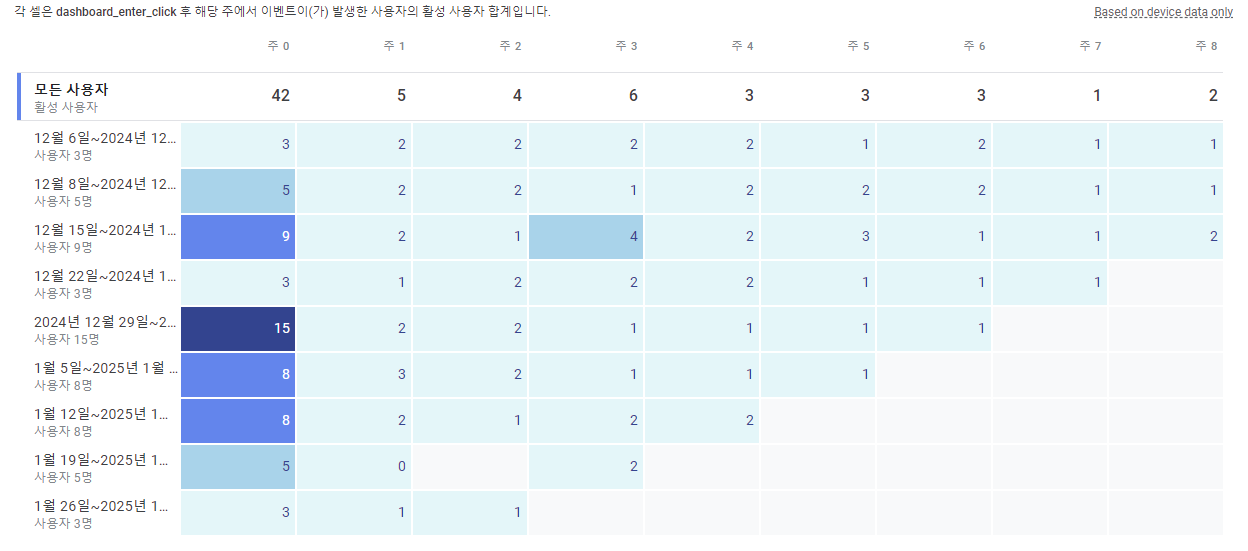

In [ ]:
# prompt: !pip koreanize-matplotlib

!pip install koreanize-matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 58.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [ ]:
df = pd.read_csv("ga_innercircle_8563.csv")
df.shape

(8563, 36)

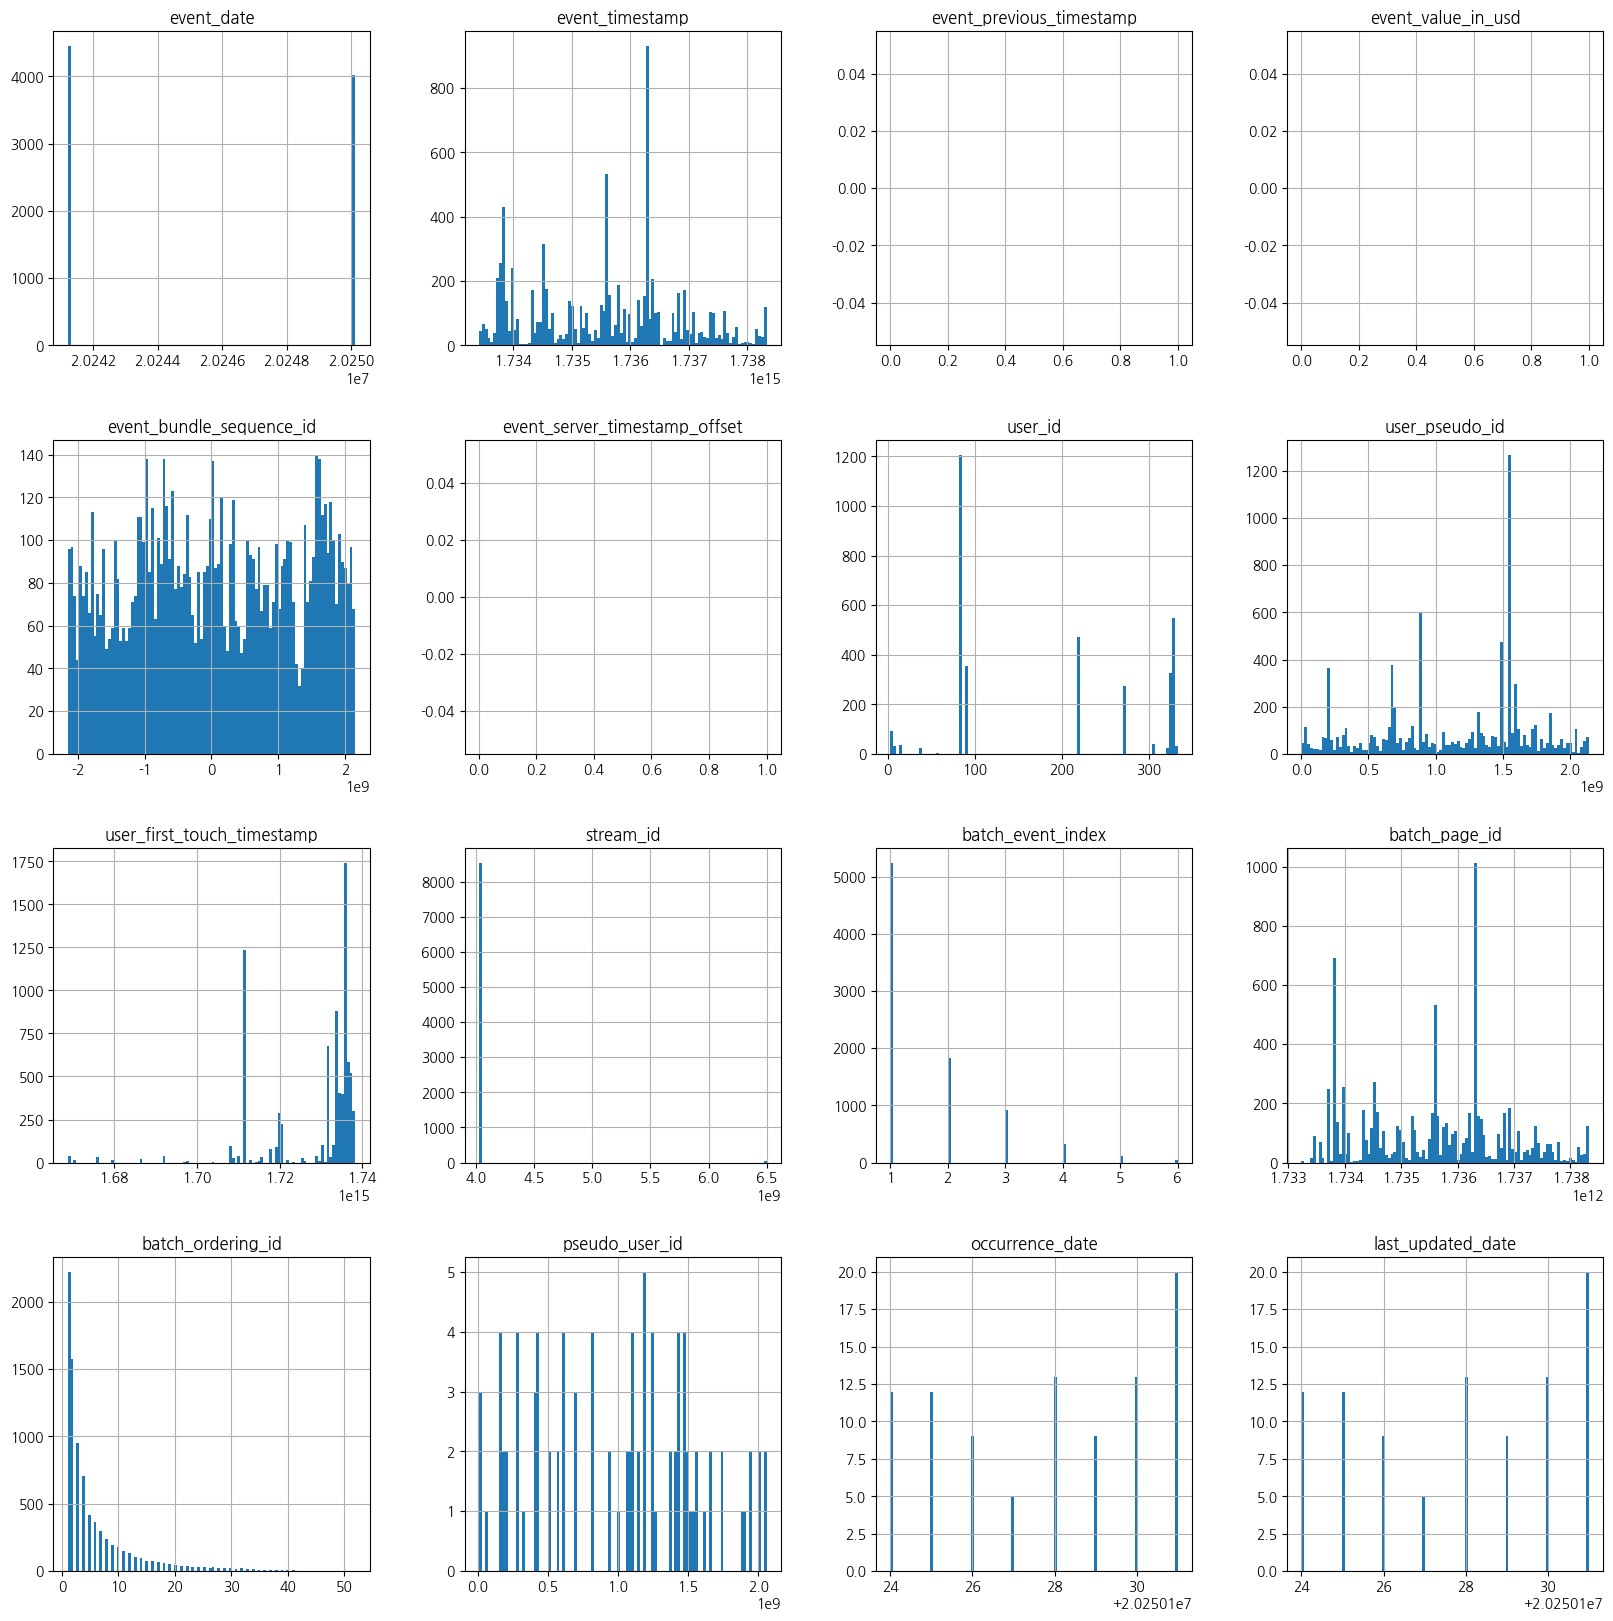

In [ ]:
df.hist(bins = 100, figsize=(20,20));

In [ ]:
df['event_time'] = pd.to_datetime(df['event_timestamp']) # 날짜형식으로 변경

df['event_date_str'] = df['event_date'].astype(str)

In [ ]:
df['event_dt'] = pd.to_datetime(df['event_date'].dropna().astype(int).astype(str), format='%Y%m%d')

## 전처리 필요

In [ ]:
import json
from pandas import json_normalize

# 1) 문자열 -> 파이썬 dict로 변환
# 2) dict 안의 'device' 키에 해당하는 딕셔너리만 추출
# 3) 그걸 바로 json_normalize로 펼쳐서 데이터프레임화
df_device_flat = (
    df['device']
      .apply(json.loads)              # 문자열 -> dict
      .apply(lambda x: x.get('device', {}))  # "device" 키값 추출
      .pipe(json_normalize)           # dict -> df로 펼치기
)

# device.* 접두사가 붙는 경우가 있다면, 아래처럼 컬럼명 간단히 조정
# df_device_flat.columns = df_device_flat.columns.str.replace('device.', '')

# 4) 기존 df와 좌우로 합치기
df = pd.concat([df, df_device_flat], axis=1)

# 잘 합쳐졌는지 확인
df.head()

,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,...,advertising_id,language,is_limited_ad_tracking,time_zone_offset_seconds,browser,browser_version,web_info.browser,web_info.browser_version,web_info.hostname,unified_screen_name
0,20241229.0,1.735406e+15,session_start,"{\n ""event_params"": [{\n ""key"": ""ga_sessio...",NaN,NaN,-1.570617e+09,NaN,NaN,7.997174e+08,...,NaN,ko-kr,No,NaN,NaN,NaN,Safari,17.2,datanugget.io,NaN
1,20241229.0,1.735406e+15,set_user_property,"{\n ""event_params"": [{\n ""key"": ""session_e...",NaN,NaN,-1.570617e+09,NaN,NaN,7.997174e+08,...,NaN,ko-kr,No,NaN,NaN,NaN,Safari,17.2,datanugget.io,NaN
2,20241229.0,1.735475e+15,first_visit,"{\n ""event_params"": [{\n ""key"": ""page_loca...",NaN,NaN,-8.775060e+08,NaN,NaN,1.271534e+09,...,NaN,ko-kr,No,NaN,NaN,NaN,Chrome,131.0.6778.205,datanugget.io,NaN
3,20241229.0,1.735475e+15,session_start,"{\n ""event_params"": [{\n ""key"": ""page_loca...",NaN,NaN,-8.775060e+08,NaN,NaN,1.271534e+09,...,NaN,ko-kr,No,NaN,NaN,NaN,Chrome,131.0.6778.205,datanugget.io,NaN
4,20241229.0,1.735475e+15,set_user_property,"{\n ""event_params"": [{\n ""key"": ""page_loca...",NaN,NaN,-8.775060e+08,NaN,NaN,1.271534e+09,...,NaN,ko-kr,No,NaN,NaN,NaN,Chrome,131.0.6778.205,datanugget.io,NaN


In [ ]:
import pandas as pd
import json
from pandas import json_normalize

# 예시: JSON 형태로 파싱해야 할 컬럼들 목록
json_cols = [
    'event_params', 'device', 'geo', 'app_info', 'traffic_source',
    'user_properties', 'user_ltv', 'event_dimensions', 'ecommerce',
    'items', 'collected_traffic_source', 'session_traffic_source_last_click',
    'publisher', 'privacy_info'
]

def parse_json(x):
    """
    JSON 문자열을 dict로 안전하게 변환.
    파싱 실패 시 빈 dict를 반환.
    """
    try:
        return json.loads(x)
    except:
        return {}

# 1) JSON 파싱 & 펼치기
for col in json_cols:
    # 1) 각 컬럼을 dict로 변환
    parsed_series = df[col].apply(parse_json)

    # 2) dict를 펼쳐서 DataFrame으로 만들기
    df_flat = json_normalize(parsed_series)

    # 3) 중복되지 않도록 새로운 컬럼명에 prefix를 추가
    df_flat.columns = [f"{col}.{subcol}" for subcol in df_flat.columns]

    # 4) 기존 df와 좌우로 합치기
    df = pd.concat([df, df_flat], axis=1)

# 2) 원본 JSON 컬럼 제거
df.drop(columns=json_cols, inplace=True)

# 결과 확인
df.head()


,event_date,event_timestamp,event_name,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,user_first_touch_timestamp,...,session_traffic_source_last_click.session_traffic_source_last_click.cm360_campaign.rendering_id,session_traffic_source_last_click.session_traffic_source_last_click.cm360_campaign.site_id,session_traffic_source_last_click.session_traffic_source_last_click.cm360_campaign.site_name,session_traffic_source_last_click.session_traffic_source_last_click.dv360_campaign,publisher.publisher,privacy_info.privacy_info.analytics_storage,privacy_info.privacy_info.ads_storage,privacy_info.privacy_info.uses_transient_token,privacy_info.privacy_info.is_limited_ad_tracking,privacy_info.privacy_info.is_ads_personalization_allowed
0,20241229.0,1.735406e+15,session_start,NaN,NaN,-1.570617e+09,NaN,NaN,7.997174e+08,1.735183e+15,...,(not set),(not set),(not set),NaN,NaN,NaN,NaN,No,NaN,NaN
1,20241229.0,1.735406e+15,set_user_property,NaN,NaN,-1.570617e+09,NaN,NaN,7.997174e+08,1.735183e+15,...,(not set),(not set),(not set),NaN,NaN,NaN,NaN,No,NaN,NaN
2,20241229.0,1.735475e+15,first_visit,NaN,NaN,-8.775060e+08,NaN,NaN,1.271534e+09,1.735475e+15,...,(not set),(not set),(not set),NaN,NaN,NaN,NaN,No,NaN,NaN
3,20241229.0,1.735475e+15,session_start,NaN,NaN,-8.775060e+08,NaN,NaN,1.271534e+09,1.735475e+15,...,(not set),(not set),(not set),NaN,NaN,NaN,NaN,No,NaN,NaN
4,20241229.0,1.735475e+15,set_user_property,NaN,NaN,-8.775060e+08,NaN,NaN,1.271534e+09,1.735475e+15,...,(not set),(not set),(not set),NaN,NaN,NaN,NaN,No,NaN,NaN


In [ ]:
df['event_params.event_params'].loc[0]

[{'key': 'ga_session_id',
  'value': {'string_value': None,
   'int_value': '1735405735',
   'float_value': None,
   'double_value': None}},
 {'key': 'page_location',
  'value': {'string_value': 'https://datanugget.io/',
   'int_value': None,
   'float_value': None,
   'double_value': None}},
 {'key': 'batch_ordering_id',
  'value': {'string_value': None,
   'int_value': '1',
   'float_value': None,
   'double_value': None}},
 {'key': 'batch_page_id',
  'value': {'string_value': None,
   'int_value': '1735405734377',
   'float_value': None,
   'double_value': None}},
 {'key': 'ga_session_number',
  'value': {'string_value': None,
   'int_value': '2',
   'float_value': None,
   'double_value': None}},
 {'key': 'session_engaged',
  'value': {'string_value': '0',
   'int_value': None,
   'float_value': None,
   'double_value': None}},
 {'key': 'page_title',
  'value': {'string_value': '브랜드의 성장박스 - 데이터너겟',
   'int_value': None,
   'float_value': None,
   'double_value': None}}]

In [ ]:
# import pandas as pd

# # event_params 컬럼의 JSON 데이터를 파싱하여 새로운 컬럼으로 변환
# def parse_event_params(row):
#     parsed_data = {}
#     if isinstance(row, list):  # row가 리스트인지 확인
#         for item in row:
#             key = item.get('key')
#             value_dict = item.get('value', {})
#             # 값이 존재하는 타입을 선택하여 저장
#             value = value_dict.get('string_value') or value_dict.get('int_value') or value_dict.get('float_value') or value_dict.get('double_value')
#             parsed_data[key] = value
#     return parsed_data

# # event_params 컬럼을 파싱하여 새로운 컬럼 추가
# df_parsed = df['event_params.event_params'].apply(parse_event_params).apply(pd.Series)

# # 기존 df와 병합
# df = pd.concat([df, df_parsed], axis=1)

# # event_params 컬럼 삭제 (원본 JSON 데이터 제거, 필요 없으면 유지 가능)
# df.drop(columns=['event_params.event_params'], inplace=True)

# # 변환된 데이터프레임 출력
# print(df.head())

import pandas as pd

# JSON 데이터를 파싱하여 새로운 컬럼으로 변환하는 함수 (event_params, user_properties.user_properties 공통)
def parse_json_column(row):
    parsed_data = {}
    if isinstance(row, list):  # row가 리스트인지 확인
        for item in row:
            key = item.get('key')
            value_dict = item.get('value', {})
            # 값이 존재하는 타입을 선택하여 저장
            value = value_dict.get('string_value') or value_dict.get('int_value') or value_dict.get('float_value') or value_dict.get('double_value')
            timestamp = value_dict.get('set_timestamp_micros')  # 타임스탬프 처리

            parsed_data[key] = value
            if timestamp:
                parsed_data[f"{key}_timestamp"] = timestamp  # 타임스탬프 컬럼 추가
    return parsed_data

# 두 개의 컬럼을 변환하여 새로운 컬럼 추가
df_event_params = df['event_params.event_params'].apply(parse_json_column).apply(pd.Series)
df_user_props = df['user_properties.user_properties'].apply(parse_json_column).apply(pd.Series)

# 기존 df와 병합
df = pd.concat([df, df_event_params, df_user_props], axis=1)

# 원본 컬럼 삭제 (필요하면 유지 가능)
df.drop(columns=['event_params.event_params', 'user_properties.user_properties'], inplace=True)

# 변환된 데이터프레임 출력
print(df.head())




   event_date  event_timestamp         event_name  event_previous_timestamp  \
0  20241229.0     1.735406e+15      session_start                       NaN   
1  20241229.0     1.735406e+15  set_user_property                       NaN   
2  20241229.0     1.735475e+15        first_visit                       NaN   
3  20241229.0     1.735475e+15      session_start                       NaN   
4  20241229.0     1.735475e+15  set_user_property                       NaN   

   event_value_in_usd  event_bundle_sequence_id  \
0                 NaN             -1.570617e+09   
1                 NaN             -1.570617e+09   
2                 NaN             -8.775060e+08   
3                 NaN             -8.775060e+08   
4                 NaN             -8.775060e+08   

   event_server_timestamp_offset  user_id  user_pseudo_id  \
0                            NaN      NaN    7.997174e+08   
1                            NaN      NaN    7.997174e+08   
2                            NaN   

In [ ]:
df['ga_session_id']

,ga_session_id
0,1735405735
1,1735405735
2,1735475147
3,1735475147
4,1735475147
...,...
8558,1736584080
8559,1736584080
8560,1736584080
8561,1736584080


In [ ]:
# prompt: df를 출력하되 모든 열이 보이게

pd.set_option('display.max_columns', None)
df

,event_date,event_timestamp,event_name,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,user_first_touch_timestamp,stream_id,platform,is_active_user,batch_event_index,batch_page_id,batch_ordering_id,pseudo_user_id,user_info,audiences,predictions,occurrence_date,last_updated_date,event_time,event_date_str,event_dt,category,mobile_brand_name,mobile_model_name,mobile_marketing_name,mobile_os_hardware_model,operating_system,operating_system_version,vendor_id,advertising_id,language,is_limited_ad_tracking,time_zone_offset_seconds,browser,browser_version,web_info.browser,web_info.browser_version,web_info.hostname,unified_screen_name,device.device.category,device.device.mobile_brand_name,device.device.mobile_model_name,device.device.mobile_marketing_name,device.device.mobile_os_hardware_model,device.device.operating_system,device.device.operating_system_version,device.device.vendor_id,device.device.advertising_id,device.device.language,device.device.is_limited_ad_tracking,device.device.time_zone_offset_seconds,device.device.browser,device.device.browser_version,device.device.web_info.browser,device.device.web_info.browser_version,device.device.web_info.hostname,device.device.unified_screen_name,geo.geo.city,geo.geo.country,geo.geo.continent,geo.geo.region,geo.geo.sub_continent,geo.geo.metro,app_info.app_info,traffic_source.traffic_source.name,traffic_source.traffic_source.medium,traffic_source.traffic_source.source,user_ltv.user_ltv,user_ltv.user_ltv.revenue,user_ltv.user_ltv.currency,user_ltv.user_ltv.revenue_in_usd,user_ltv.user_ltv.sessions,user_ltv.user_ltv.engagement_time_millis,user_ltv.user_ltv.purchases,user_ltv.user_ltv.engaged_sessions,user_ltv.user_ltv.session_duration_micros,event_dimensions.event_dimensions,ecommerce.ecommerce,items.items,collected_traffic_source.collected_traffic_source,collected_traffic_source.collected_traffic_source.manual_campaign_id,collected_traffic_source.collected_traffic_source.manual_campaign_name,collected_traffic_source.collected_traffic_source.manual_source,collected_traffic_source.collected_traffic_source.manual_medium,collected_traffic_source.collected_traffic_source.manual_term,collected_traffic_source.collected_traffic_source.manual_content,collected_traffic_source.collected_traffic_source.manual_source_platform,collected_traffic_source.collected_traffic_source.manual_creative_format,collected_traffic_source.collected_traffic_source.manual_marketing_tactic,collected_traffic_source.collected_traffic_source.gclid,collected_traffic_source.collected_traffic_source.dclid,collected_traffic_source.collected_traffic_source.srsltid,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.campaign_id,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.campaign_name,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.source,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.medium,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.term,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.content,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.source_platform,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.creative_format,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.marketing_tactic,session_traffic_source_last_click.session_traffic_source_last_click.google_ads_campaign,session_traffic_source_last_click.session_traffic_source_last_click.cross_channel_campaign.campaign_id,session_traffic_source_last_click.session_traffic_source_last_click.cross_channel_campaign.campaign_name,session_traffic_source_last_click.session_traffic_source_last_click.cross_channel_campaign.source,session_traffic_source_last_click.session_traffic_source_last_cli

In [ ]:
# # prompt: df를 csv파일로 저장

# # 기존 코드는 그대로 유지하고, 마지막에 df를 csv 파일로 저장하는 코드를 추가합니다.
# df.to_csv('processed_ga_data_twice.csv', index=False)  # index=False로 인덱스를 저장하지 않도록 설정


In [ ]:
import pandas as pd

# 데이터프레임의 컬럼명 리스트 가져오기
column_counts = pd.Series(df.columns).value_counts().reset_index()

# 컬럼명 변경
column_counts.columns = ['컬럼명', '개수']
column_counts

,컬럼명,개수
0,batch_page_id,2
1,user_id,2
2,platform,2
3,batch_ordering_id,2
4,event_date,1
...,...,...
178,geo.geo.sub_continent,1
179,geo.geo.metro,1
180,app_info.app_info,1
181,traffic_source.traffic_source.name,1


In [ ]:
# prompt: df에 user_id 라는 컬럼이 2개인데 한개로 합쳐줘

# 중복된 'user_id' 컬럼을 하나로 합치는 코드 추가

# 먼저, 중복된 컬럼명을 찾습니다.
duplicate_columns = df.columns[df.columns.duplicated()]

# 중복된 컬럼이 있다면,
if 'user_id' in duplicate_columns:
    # 첫 번째 'user_id' 컬럼을 기준으로 두 번째 'user_id' 컬럼의 값을 채웁니다.
    # 첫 번째 'user_id' 컬럼에 NaN 값이 있는 경우 두 번째 'user_id' 컬럼의 값으로 채웁니다.
    df['user_id'] = df['user_id'].fillna(df.iloc[:, df.columns.get_loc('user_id') + 1])

    # 두 번째 'user_id' 컬럼을 삭제합니다.
    df = df.loc[:, ~df.columns.duplicated()]

# 결과 확인
print(df.head())


   event_date  event_timestamp         event_name  event_previous_timestamp  \
0  20241229.0     1.735406e+15      session_start                       NaN   
1  20241229.0     1.735406e+15  set_user_property                       NaN   
2  20241229.0     1.735475e+15        first_visit                       NaN   
3  20241229.0     1.735475e+15      session_start                       NaN   
4  20241229.0     1.735475e+15  set_user_property                       NaN   

   event_value_in_usd  event_bundle_sequence_id  \
0                 NaN             -1.570617e+09   
1                 NaN             -1.570617e+09   
2                 NaN             -8.775060e+08   
3                 NaN             -8.775060e+08   
4                 NaN             -8.775060e+08   

   event_server_timestamp_offset  user_id  user_pseudo_id  \
0                            NaN      NaN    7.997174e+08   
1                            NaN      NaN    7.997174e+08   
2                            NaN   

In [ ]:
# prompt: df['user_id'],value_counts()

df['user_id'].value_counts()


,count
user_id,
85.0,1207
329.0,489
219.0,470
91.0,354
324.0,309
271.0,275
3.0,94
328.0,51
304.0,39


# 아하모먼트 - 파워유저란 누구인가

329번 유저

In [ ]:
# prompt: user_id가 329인 사람의 데이터프레임만 따로 생성

# user_id가 329인 사람의 데이터프레임만 따로 생성
user_329_df = df[df['user_id'] == 329]
user_329_df


,event_date,event_timestamp,event_name,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,user_first_touch_timestamp,stream_id,platform,is_active_user,batch_event_index,batch_page_id,batch_ordering_id,pseudo_user_id,user_info,audiences,predictions,occurrence_date,last_updated_date,event_time,event_date_str,event_dt,category,mobile_brand_name,mobile_model_name,mobile_marketing_name,mobile_os_hardware_model,operating_system,operating_system_version,vendor_id,advertising_id,language,is_limited_ad_tracking,time_zone_offset_seconds,browser,browser_version,web_info.browser,web_info.browser_version,web_info.hostname,unified_screen_name,device.device.category,device.device.mobile_brand_name,device.device.mobile_model_name,device.device.mobile_marketing_name,device.device.mobile_os_hardware_model,device.device.operating_system,device.device.operating_system_version,device.device.vendor_id,device.device.advertising_id,device.device.language,device.device.is_limited_ad_tracking,device.device.time_zone_offset_seconds,device.device.browser,device.device.browser_version,device.device.web_info.browser,device.device.web_info.browser_version,device.device.web_info.hostname,device.device.unified_screen_name,geo.geo.city,geo.geo.country,geo.geo.continent,geo.geo.region,geo.geo.sub_continent,geo.geo.metro,app_info.app_info,traffic_source.traffic_source.name,traffic_source.traffic_source.medium,traffic_source.traffic_source.source,user_ltv.user_ltv,user_ltv.user_ltv.revenue,user_ltv.user_ltv.currency,user_ltv.user_ltv.revenue_in_usd,user_ltv.user_ltv.sessions,user_ltv.user_ltv.engagement_time_millis,user_ltv.user_ltv.purchases,user_ltv.user_ltv.engaged_sessions,user_ltv.user_ltv.session_duration_micros,event_dimensions.event_dimensions,ecommerce.ecommerce,items.items,collected_traffic_source.collected_traffic_source,collected_traffic_source.collected_traffic_source.manual_campaign_id,collected_traffic_source.collected_traffic_source.manual_campaign_name,collected_traffic_source.collected_traffic_source.manual_source,collected_traffic_source.collected_traffic_source.manual_medium,collected_traffic_source.collected_traffic_source.manual_term,collected_traffic_source.collected_traffic_source.manual_content,collected_traffic_source.collected_traffic_source.manual_source_platform,collected_traffic_source.collected_traffic_source.manual_creative_format,collected_traffic_source.collected_traffic_source.manual_marketing_tactic,collected_traffic_source.collected_traffic_source.gclid,collected_traffic_source.collected_traffic_source.dclid,collected_traffic_source.collected_traffic_source.srsltid,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.campaign_id,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.campaign_name,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.source,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.medium,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.term,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.content,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.source_platform,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.creative_format,session_traffic_source_last_click.session_traffic_source_last_click.manual_campaign.marketing_tactic,session_traffic_source_last_click.session_traffic_source_last_click.google_ads_campaign,session_traffic_source_last_click.session_traffic_source_last_click.cross_channel_campaign.campaign_id,session_traffic_source_last_click.session_traffic_source_last_click.cross_channel_campaign.campaign_name,session_traffic_source_last_click.session_traffic_source_last_click.cross_channel_campaign.source,session_traffic_source_last_click.session_traffic_source_last_cli

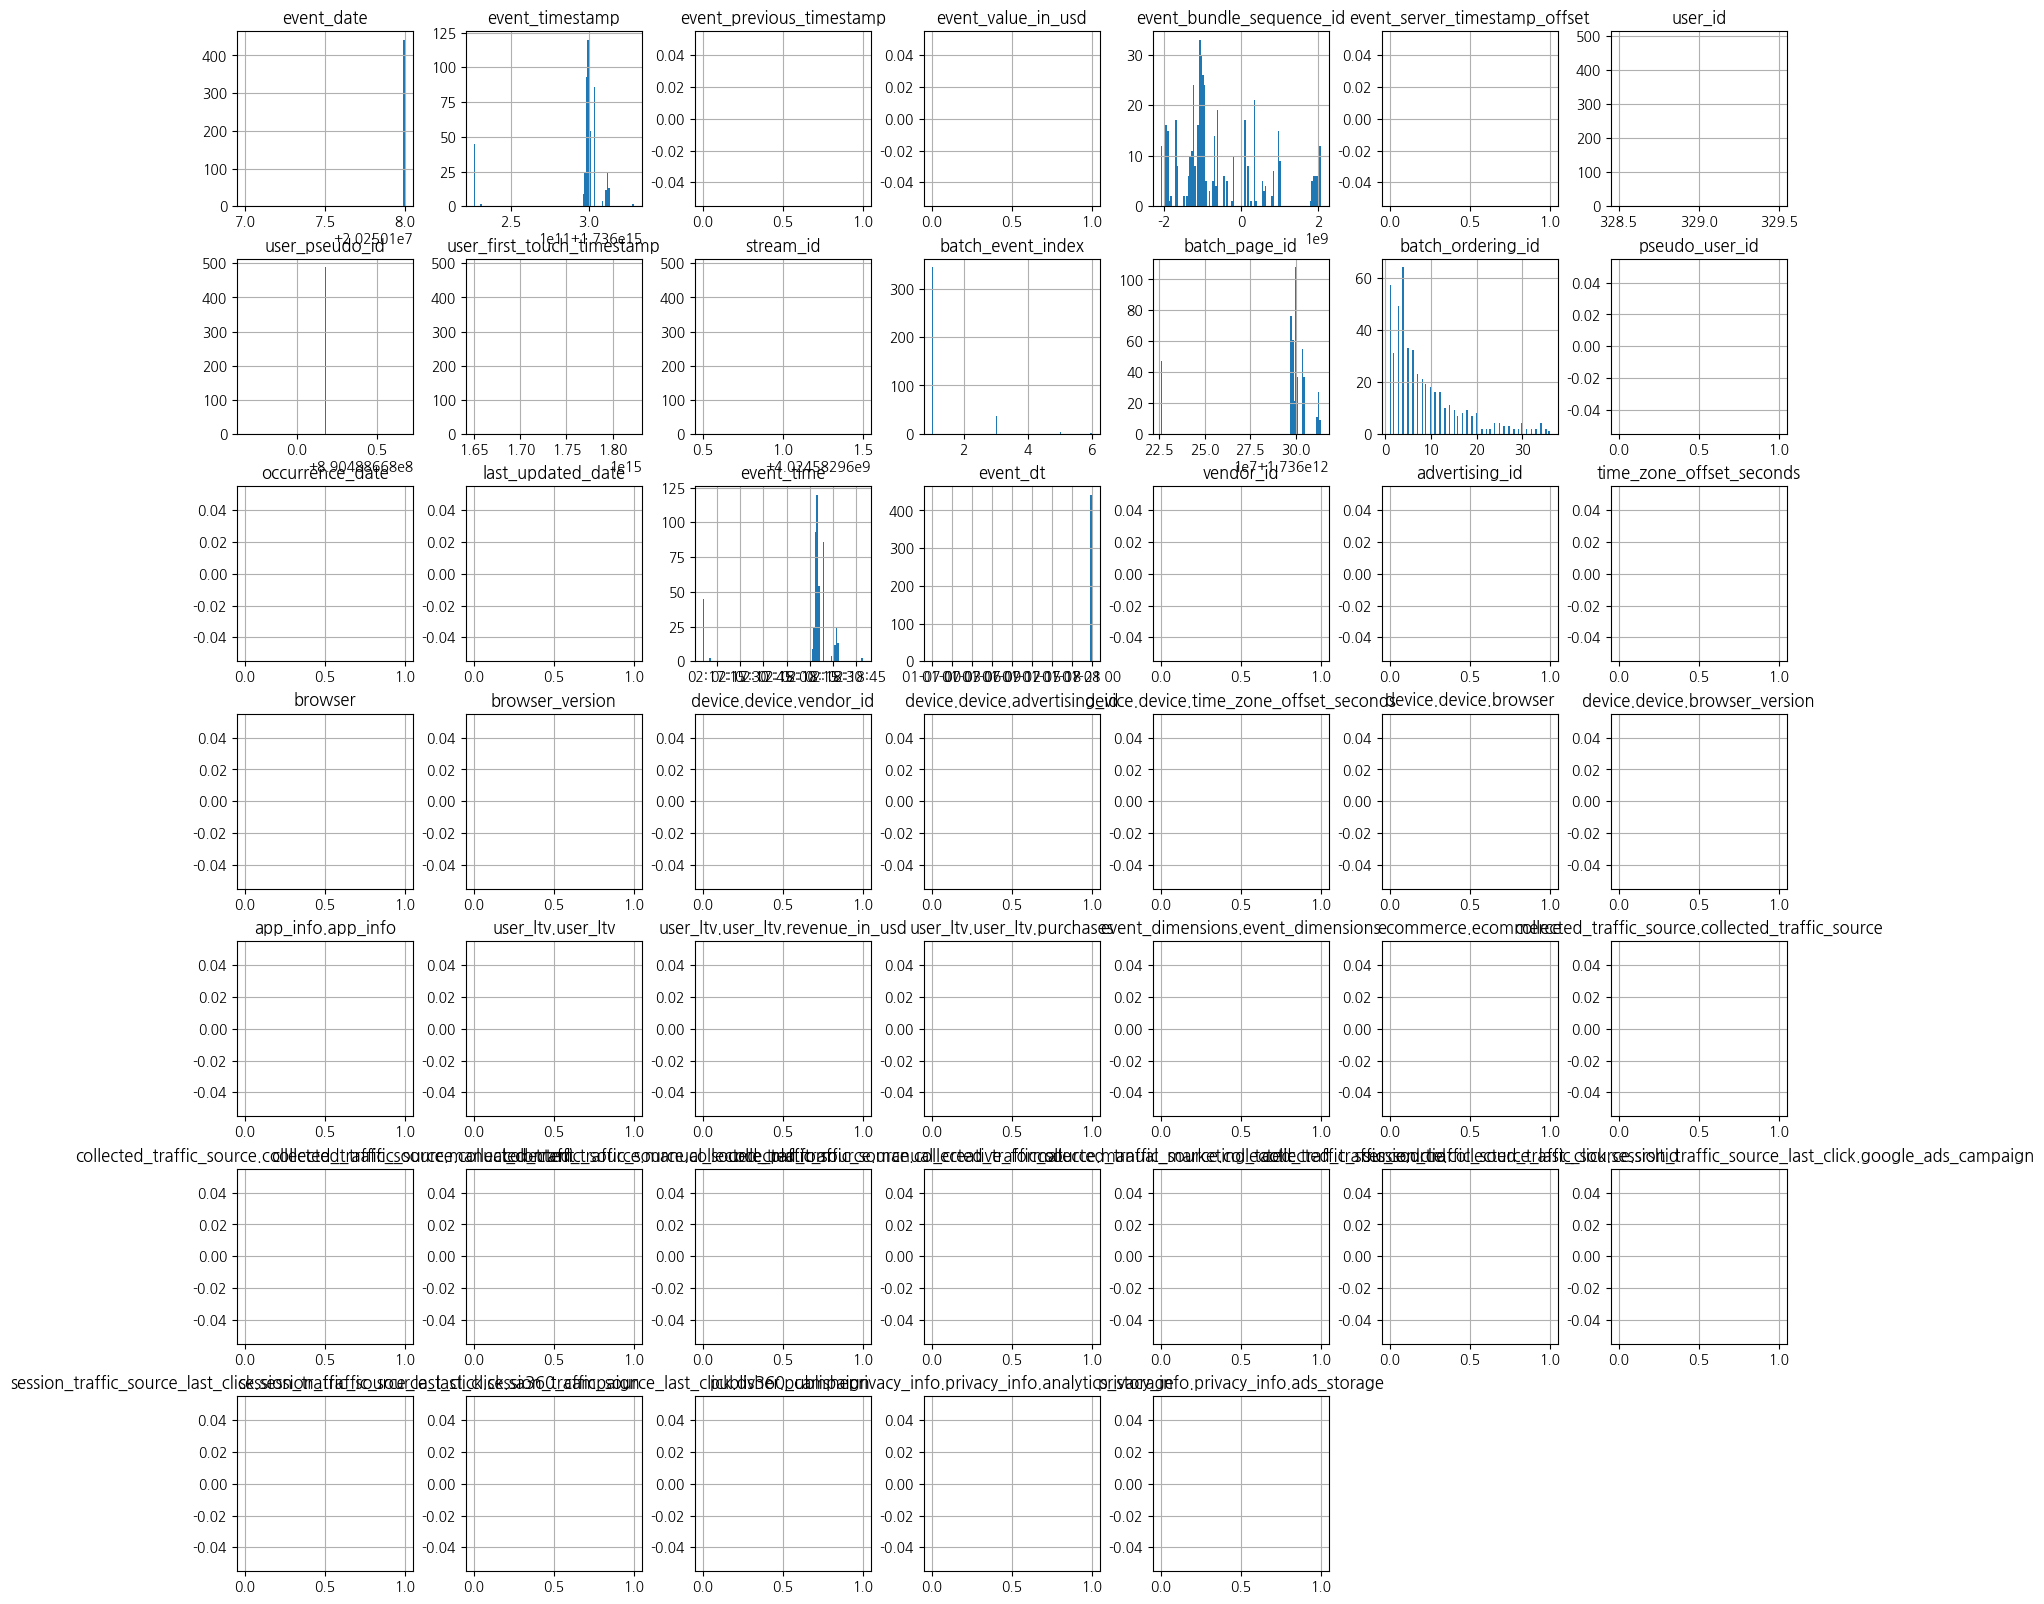

In [ ]:
user_329_df.hist(bins = 100, figsize=(20,20));

이처럼 유저별로 접속횟수, 접속 시간대에 따라 이 유저가 누구인지에 대한 추측

이를 바탕으로 유저에게 필요한 내용을 넛지마케팅 전략 기획 가능

Ex. 화요일 15시에 정기적으로 길게 접속하는 유저라면 수요일 오전 또는 화요일 오후늦게즈음 보고서 작성일 확률이 높음 -> 화요일 점심즈음 유저에게 도움이될만한 인사이트 내용 메일 발송 및 이와 같은 서비스 구독제 프로그램 기획.